# Transformers

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 03/03/2025   | Martin | Created   | Created notebook for Transformers Chapter. Started text generation section and exploring different decoding methods | 
| 04/03/2025   | Martin | Update   | Completed top k and top p methods for decoding section | 
| 06/03/2025   | Martin | Update   | Completed text generation section | 
| 09/03/2025   | Martin | Update   | Started Sentiment analysis section | 
| 10/03/2025   | Martin | Update   | Completed Sentiment section. Started on Open-domain questions | 

# Content

* [Introduction](#introduction)
* [Text Generation](#text-generation)
* [Sentiment Analysis](#sentiment-analysis)

# Introduction

Transformers perform a similar function to RNNs in processing sequential data but are an improvement since they do not require processing of data in order. Results in better parallelisation and faster training.

They can be pretrained on large bodies of unlabeled data and then fintuned for other tasks

__Perform Functions__

* Translation
* Question answering
* Text summarisations

__2 Common Architectures__

1. Bidirectional Encoder Represetations for Transformers (BERT)
2. Generative Pretrained Transformers (GPTs)

__Recipes Covered__

1. Text generation
2. Sentiment Analysis
3. Text classification: sarcasm detection
4. Question answering

---

# Text Generation

Using GPT-2 from __HuggingFace__

_GPT-2:_ Second generation of the GPT architecture. It showed show generative language models can acquire knowledge and process long-range dependencies thanks to pretraining on a large, diverse corpus of contiguous text

In [1]:
import tensorflow as tf

from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
GPT2 = TFGPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)

2025-03-04 23:12:20.017064: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 23:12:22.302923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741101143.101419    1444 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741101143.337128    1444 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 23:12:25.479633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Set seed
SEED = 34
MAX_LEN = 70 # set the maximum context length
tf.random.set_seed(SEED)

## Decoding Methods

These are different methods on how to determine the next word

1. __Greedy Search__ - Select the word with the highest probability
2. [__Beam Search__](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24/) - Picks the N best sequences and considers the probabilities of the combination of all the preceding words + current word. Each branching sequence is retrained against the model conditioned on all previously selected words till the end of a sentence ("") has the highest probability
3. __Sample-based decoding__ - Randomly selecting the next token according to a probability distribution. The distribution is created based on the probabilities for each word, which are conditional probabilities
4. __Top K Sampling__ - Entire probability mass is shifted to only the top $k$ words. This increases the chances of high probability words occurring and decreases the chances of low probability words
5. __Top P Sampling (Nucleus Sampling)__ - Choose the smallest set of words whose total probability is greater than $p$. The probability mass function is rescaled to these set of words. This means that the size of the set of words changes with each step

### 1. Greedy Search

Model tends to repeat itself after awhile, because the high probability words mask the less probable ones which prevents any exploration for diverse combinations

In [3]:
# Sample texts/ sequences
input_sequence_1 = "I don't know about you, but there's only one thing I want to do after a long day of work"
input_sequence_2 = "There are times when I am really tired of people, but I feel lonely too."

In [9]:
# 1. Greedy Search
# Encode context the generation is conditioned on
input_ids = tokenizer.encode(input_sequence_2, return_tensors='tf')

# Generate text until the output length (including context length - input)
greedy_output = GPT2.generate(input_ids, max_length=MAX_LEN)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens = True))

Output:
----------------------------------------------------------------------------------------------------
There are times when I am really tired of people, but I feel lonely too. I feel like I am not in the right place at the right time. I feel like I am not in the right place at the right time. I feel like I am not in the right place at the right time. I feel like I am not in the


### 2. Beam Search

Selects the N best sequences by selecting the best N combinations and creating branching possibilities of next words. Each branch is retrained with the previously selected sequence to get a new set of possible word probabilities.

e.g For the sentence: "I am going to the ____"

Possible predictions:

* Park 0.6
* Zoo 0.1
* Doctor 0.25
* Supermarket 0.05

With N=2, the beam search will rerun the model on "I am going to the __Park__" and "I am going to the __Supermarket__" and then repeat the process for each result

Each iteration will select the highest probability across __ALL__ branches. This method increases the exploration of possible words

In [ ]:
# 2. Beam Search
input_ids = tokenizer.encode(input_sequence_2, return_tensors='tf')

beam_outputs = GPT2.generate(
  input_ids,
  max_length=200,
  num_beams=5,
  no_repeat_ngram_size=2,
  num_return_sequences=5,
  early_stopping=True
)

print('')
print("Output:\n" + 100 * '-')

# we have 5 different outputs
for i, beam_output in enumerate(beam_outputs):
  print(f"{i+1}: {tokenizer.decode(beam_output, skip_special_tokens=True)}")


Output:
----------------------------------------------------------------------------------------------------
1: There are times when I am really tired of people, but I feel lonely too. I don't know what to do with myself.

"I feel like I can't do anything about it. It's like, 'Oh my God, I'm going to have to get out of here.'"
2: There are times when I am really tired of people, but I feel lonely too. I don't know what to do with myself.

"I feel like I can't do anything about it. It's like, 'Oh my God, I'm going to have to get out of here.' I just want to go home."
3: There are times when I am really tired of people, but I feel lonely too. I don't know what to do with myself.

"I feel like I can't do anything about it. It's like, 'Oh my God, I'm going to have to get out of here.' I have no idea what's going on."
4: There are times when I am really tired of people, but I feel lonely too. I don't know what to do with myself.

"I feel like I can't do anything about it. It's like, 'Oh my

### 3. Sample-based Decoding

Randomly selecting the next token according to its probability distribution. 

Convert the scores into probability distributions (conditional distributions) and randomly select a token

_Temperature:_ Controls the "sharpness" of the probability distribution

* Low Temperature (0.1-0.5): Makes high-probability more likely to be chosen (Leptokurtic) i.e More focused and predictable text
* High Temperature (0.8-1.5): Flattens the distribution and gives more equal chance to lower probability tokens (Platykurtic). Increases diversity, bit risks incoherence

__OUTCOME:__ Have a more varied output, but sometimes is incoherent esp. with a higher temperature value

In [16]:
# 3. Sample-based decoding
input_ids = tokenizer.encode(input_sequence_1, return_tensors='tf')

sample_output = GPT2.generate(
  input_ids,
  do_sample=True,
  max_length=MAX_LEN,
  top_k=0,
  temperature=0.2 # relatively low temperature value to maintain coherence
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I don't know about you, but there's only one thing I want to do after a long day of work. I want to go to the gym and get my body ready for the next day. I want to go to the gym and get my body ready for the next day. I want to go to the gym and get my body ready


In [17]:
# with a higher temperature value to increase variability in tokens
sample_output = GPT2.generate(
  input_ids,
  do_sample=True,
  max_length=MAX_LEN,
  top_k=0,
  temperature=0.8 # relatively low temperature value to maintain coherence
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I don't know about you, but there's only one thing I want to do after a long day of work. This is the day I leave the house," she said.

"You have to be ready for something," Zhaoxiu said. "I am afraid to leave."

She didn't leave alone.




### 4. Top K Sampling

In [4]:
input_ids = tokenizer.encode(input_sequence_1, return_tensors='tf')

sample_output = GPT2.generate(
  input_ids,
  do_sample=True,
  max_length=MAX_LEN,
  top_k=50
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True), '...')

Output:
----------------------------------------------------------------------------------------------------
I don't know about you, but there's only one thing I want to do after a long day of work. I have a great time. And that day I'm going to stop getting sick. Because you can't sit up with yourself and eat nothing, you have to sit up with yourself."

If you are on social media, ...


### 5. Top P Sample/ Nucleus Sampling

In [5]:
input_ids = tokenizer.encode(input_sequence_1, return_tensors='tf')

sample_output = GPT2.generate(
  input_ids,
  do_sample=True,
  max_length=MAX_LEN,
  top_k=0,
  top_p=0.8
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True), '...')

Output:
----------------------------------------------------------------------------------------------------
I don't know about you, but there's only one thing I want to do after a long day of work that I can do. I want to get back to work, and get back to helping the community."

But on a personal note, Zuckerman says he hopes his decision will provide him with hope for his daughter.
 ...


### Combining both approaches

In [11]:
input_ids = tokenizer.encode(input_sequence_1, return_tensors='tf')

sample_outputs = GPT2.generate(
  input_ids,
  do_sample=True,
  max_length=2*MAX_LEN,
  top_k=50,
  top_p=0.8,
  num_return_sequences=5
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print(f"{i+1}: {tokenizer.decode(sample_output, skip_special_tokens=True)}")
  print('')

Output:
----------------------------------------------------------------------------------------------------
1: I don't know about you, but there's only one thing I want to do after a long day of work. I want to make my wife happy."

When the day started, the young woman told me she felt sorry for her daughter, who was suffering from an autism spectrum disorder. She said that after working long hours, she felt like a burden. She had no idea that she had to take a stand on behalf of other children.

"I want my kids to learn how to be successful," the woman said. "I want them to be able to do everything in their power to be successful, and to do that because they know what it's like to have no

2: I don't know about you, but there's only one thing I want to do after a long day of work. I want to do this for you, for your children and for your grandchildren. I'm going to make sure you get a good education."

A family member of mine, an Australian citizen, went on to write a long story in 

Remaining examples are just different prompts, so stopping here

---

# Sentiment Analysis

`DistilBERT`: Lightweight version of `BERT` used to handle common problem of sentiment analysis

Goal:
* Predict the sentiment of tweets (positive, neutral, negative)
* Identify parts of the tweet that define the sentiment

In [31]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from collections import Counter
np.random.seed(0)

# Keras imports
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, GRU, Embedding
from keras.layers import Activation, Bidirectional, GlobalMaxPool1D, GlobalMaxPool2D, Dropout
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import RMSprop, Adam
from keras.initializers import Constant
from scikeras.wrappers import KerasClassifier

# Text processing usint nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Transformer models
import transformers
from transformers import AutoTokenizer
from tokenizers import BertWordPieceTokenizer

# sklearn modules
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [4]:
# # To download necesasry nltk data
# ## Used: 'stopwords', 'punkt', 'punkt_tab', 'wordnet'
# import nltk
# nltk.download('wordnet')

In [5]:
stop = set(stopwords.words('english'))

## Stemmers vs. Lemmatizers

* _Stemmers:_ Remove common suffixes from the end of a word token (e.g change, changing, changes -> chang)
* _Lemmatization:_ Integrates meaning into the word representation based on the context and type of word (e.g information -> information, informative -> informative)

Lemmatizers generally provide a better interpretation of the words, but require a encoding space, since there are more words that are different representations

* `WordNetLemmatizer` - The `WordNet` dataset trained lemmatizer
* `PorterStemmer` - Implements the stemmer to provide  standardised word format

## Data Processing

Steps of data cleaning:
1. Remove NaN values
2. Remove website urls, non-characters and replace swear words
3. Remove HTML
4. Remove Emojis
5. Remove characters from words that have repeated characters (>3)

In [ ]:
def basic_cleaning(text: str):
  """
  - Removes url details
  - Removes single characters
  - Replaces censored words (****) with "swear"

  Args:
      text (str): Text to be cleaned

  Returns:
      text: Cleaned text
  """
  text = re.sub(r"http:?//www.\.\S+\.com", '', text)
  text = re.sub(r"[^A-Za-z\s]", '', text)
  text = re.sub(r"\*+", 'swear', text) # capture words that are censored
  return text

def remove_html(text: str):
  """Removes html tags

  Args:
      text (str): Text to be cleaned

  Returns:
      (str): Text without HTML tags
  """
  html = re.compile(r"<.*?>")
  return html.sub(r'', text)

def remove_emoji(text: str):
  """Remove emojis from text

  Args:
      text (str): Text to be cleaned

  Returns:
      (str): Text without emojis
  """
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

def remove_multiplechars(text: str):
    """Remove multiple instances of the same character

    Args:
        text (str): Text to be cleaned

    Returns:
        (str): Text that have multiple characters, repeated characters are removed
    """
    text = re.sub(r'(.)\1{3,}', r'\1', text)
    return text

def clean(df: pd.DataFrame):
    """
    Apply the cleaning functions above to a dataframe
    """
    for col in ['text']:
        df[col] = df[col].astype(str).apply(lambda x:basic_cleaning(x))
        df[col] = df[col].astype(str).apply(lambda x:remove_emoji(x))
        df[col] = df[col].astype(str).apply(lambda x:remove_html(x))
        df[col] = df[col].astype(str).apply(lambda x:remove_multiplechars(x))

    return df

def fast_encode(
    text: str,
    tokenizer,
    chunk_size: int=256,
    maxlen: int=128
):
    """Applies tokeniser to encode text into batches of fixed size
    - Applies truncation and padding to ensure fixed length
    - Tokenises the texts in chunks based on the chunk_size
    - Sentences that are longer than the chunk_size are split into separate lists

    Args:
        text (str): Text to be processed
        tokenizer (Tokenizer): Tokeniser used
        chunk_size (int, optional): Number of words per batch. Defaults to 256.
        maxlen (int, optional): Maximum length per sentence. Defaults to 128.

    Returns:
        (np.array): Array of tokenized sentences, split by max length of chunks
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []

    for i in range(0, len(text), chunk_size):
        text_chunk = text[i:i+chunk_size].tolist()
        enc = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in enc])
    return np.array(all_ids)

def preprocess_news(
    df: pd.DataFrame,
    stop: list,
    n: int=1,
    col: str='text'
):
    """Preprocess dataframe and create corpus

    Args:
        df (pd.DataFrame): Dataframe containing texts to be transformed
        stop (list): List of stopwords
        n (int, optional): Number of words to be lemmatised at one go. Defaults to 1.
        col (str, optional): Columns of text values. Defaults to 'text'.

    Returns:
        _type_: _description_
    """
    new_corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    
    for text in df[col]:
        words = [w for w in word_tokenize(text) if (w not in stop)]
        words = [lem.lemmatize(w) for w in words if(len(w) > n)]
        new_corpus.append(words)
    
    new_corpus = [word for l in new_corpus for word in l]
    return new_corpus

In [7]:
df = pd.read_csv("../data/sentiment/train.csv")
df = df.dropna()
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [8]:
# Apply the processing
df_clean = clean(df)

## EDA

In [9]:
df_clean.shape

(27480, 4)

Text(0, 0.5, 'Tweet Count')

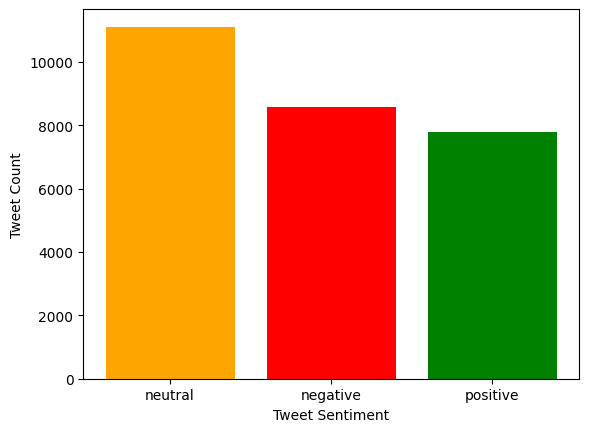

In [10]:
# Distribution of tweets by sentiment
colours = ['orange', 'red', 'green']
plt.bar(df['sentiment'].unique(), df['sentiment'].value_counts(), color=colours)
plt.xlabel('Tweet Sentiment')
plt.ylabel('Tweet Count')

Text(0.5, 0.98, 'Distribution of number Words in Tweets')

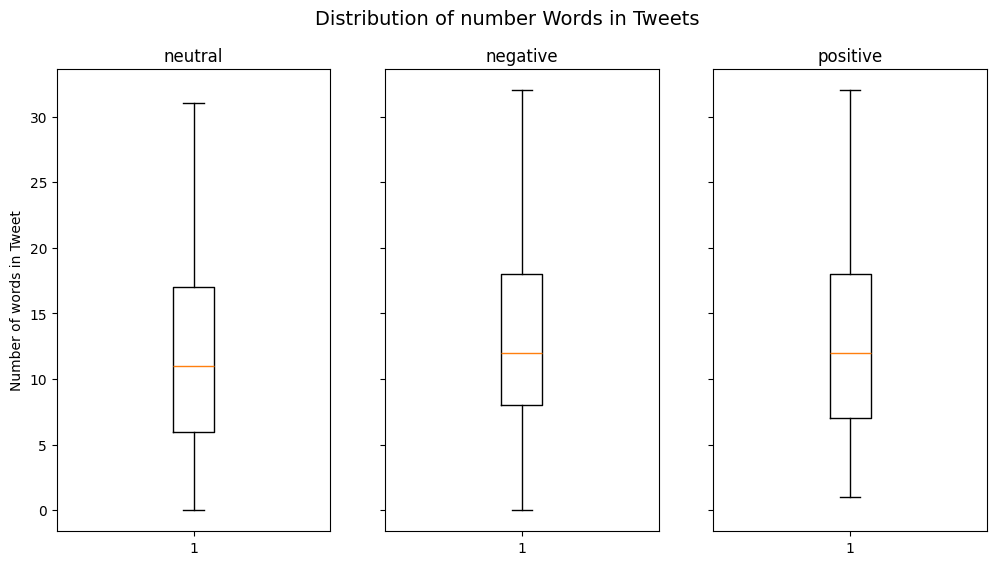

In [11]:
# Distribution of lenght of tweet by sentiment
sent = df['sentiment'].unique()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6), sharey=True)

for i in range(3):
  lengths = df_clean[df_clean['sentiment'] == sent[i]]['text'].str.split().str.len()
  ax[i].boxplot(lengths)
  ax[i].set_title(sent[i])
ax[0].set_ylabel('Number of words in Tweet')
fig.suptitle("Distribution of number Words in Tweets", fontsize=14)

Text(0.5, 0.98, 'Common words in tweet text')

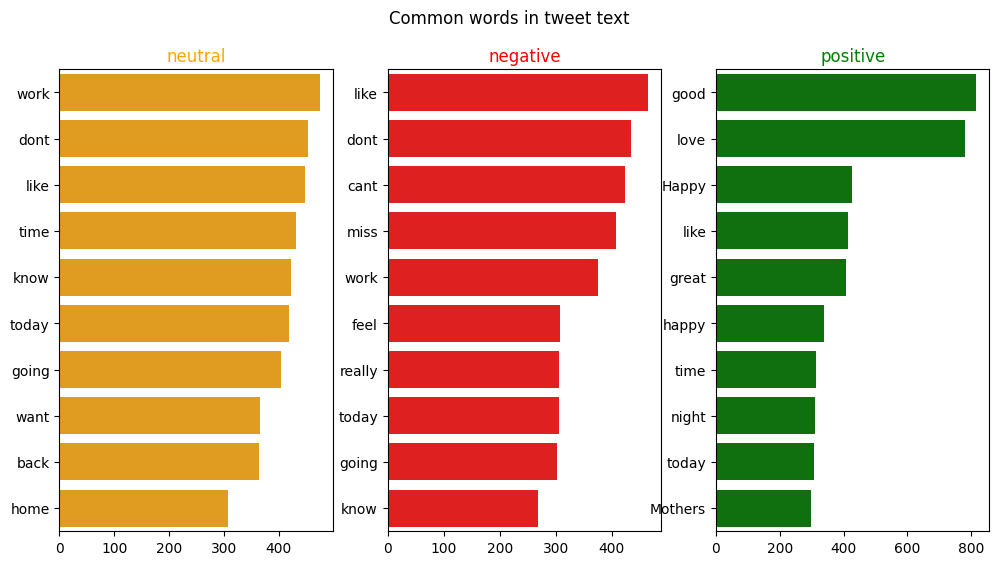

In [12]:
# Most common words taht appear in the top 10 from all the groups
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
for i in range(3):
  plots = df_clean[df_clean['sentiment'] == sent[i]]
  corpus_train = preprocess_news(plots, stop, n=3)
  counter = Counter(corpus_train)
  most = counter.most_common()
  x = []
  y = []
  for word, count in most[:10]:
    if word not in stop:
      x.append(word)
      y.append(count)

  sns.barplot(x=y, y=x, ax=ax[i], color=colours[i])
  ax[i].set_title(sent[i], color=colours[i])
fig.suptitle("Common words in tweet text")

## Preprocessing

One-hot encoding for labels

In [13]:
df_clean_selection = df_clean.sample(frac=1)
X = df_clean_selection.text.values
y = pd.get_dummies(df_clean_selection['sentiment'])

In [17]:
tokeniser = text.Tokenizer(num_words=20000) # limit the number of words used to reduce memory usage
tokeniser.fit_on_texts(list(X))
list_tokenized_train = tokeniser.texts_to_sequences(X)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=128) # Max sequence length = 128

## Model: DistilBert

`DistilBert`: Light version of BERT. Contains a tokenizer and an embedding matrix. Reduces the number of parameters by 60%, but maintains 97% performance against the original BERT model

Will not be retraining the model

In [23]:
tokeniser = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Save the loaded tokeniser locally
save_path = "./models/distilbert_base_uncased"
if not os.path.exists(save_path):
  os.makedirs(save_path)
tokeniser.save_pretrained(save_path)

# Reload with the huggingface tokenizer library
fast_tokeniser = BertWordPieceTokenizer('models/distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokeniser

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [28]:
# Encode data
X = fast_encode(df_clean_selection.text.astype(str), fast_tokeniser, maxlen=128)
X.shape

(27480, 128)

In [32]:
# Initialise transformer layer
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

I0000 00:00:1741604515.058069    1446 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.


In [37]:
embedding_size = 128
input_ = Input(shape=(100,))

inp = Input(shape=(128, ))

embedding_matrix = transformer_layer.weights[0].numpy()

# Create the model architecture
x = Embedding(
  embedding_matrix.shape[0],
  embedding_matrix.shape[1],
  embeddings_initializer=Constant(embedding_matrix),
  trainable=False
)(inp)
x = Bidirectional(LSTM(50, return_sequences=True))(x)
x = Bidirectional(LSTM(25, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu', kernel_regularizer='L1L2')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model_distilbert = Model(inputs=[inp], outputs=x)

In [38]:
model_distilbert.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 128, 768)       │    23,440,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 100)       │       327,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128, 50)        │        25,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 50)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,796,399 (90.78 MB)

 Trainable params: 355,503 (1.36 MB)

 Non-trainable params: 23,440,896 (89.42 MB)

In [41]:
model_distilbert.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [42]:
model_distilbert.fit(
  X,
  y,
  batch_size=32,
  epochs=10,
  validation_split=0.1
)

Epoch 1/10


/mnt/d/Software/venv/py310_env/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(None, 128))
  warnings.warn(msg)
I0000 00:00:1741604890.417917   13826 cuda_dnn.cc:529] Loaded cuDNN version 90300


772/773 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3975 - loss: 1.0813

/mnt/d/Software/venv/py310_env/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(None, 128))
  warnings.warn(msg)


773/773 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.3977 - loss: 1.0811 - val_accuracy: 0.6474 - val_loss: 0.7795
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.6780 - loss: 0.7607 - val_accuracy: 0.7314 - val_loss: 0.6332
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.7353 - loss: 0.6522 - val_accuracy: 0.7434 - val_loss: 0.6219
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7494 - loss: 0.6227 - val_accuracy: 0.7500 - val_loss: 0.6112
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.7632 - loss: 0.6008 - val_accuracy: 0.7547 - val_loss: 0.5813
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.7717 - loss: 0.5814 - val_accuracy: 0.7558 - val_loss: 0.5885
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.7760 - loss: 0.5572 - val_accuracy: 0.7493 - val_loss: 0.5905
Epoch 8/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.7910 - loss: 0.5377 - val_accurac

## Inference

In [43]:
df_test = pd.read_csv('../data/sentiment/test.csv')
df_test = df_test.dropna()
df_clean_test = clean(df_test)

X_test = fast_encode(df_clean_test.text.values.astype(str), fast_tokeniser, maxlen=128)
y_test = df_clean_test['sentiment']

In [48]:
y_preds = model_distilbert.predict(X_test)
y_predictions = pd.DataFrame(y_preds, columns=['negative', 'neutral', 'positive'])
y_predictions_final = y_predictions.idxmax(axis=1)
accuracy = accuracy_score(y_test, y_predictions_final)

print(f"Final accuracy: {accuracy:.2f}")

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Final accuracy: 0.76
